# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    # Місце для вашого коду
    self.dense1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    # Місце для вашого коду
    self.dense2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    # Місце для вашого коду
    self.out = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.dense1(x, activation=0)  # активація сигмоїда
    x = self.dense2(x, activation=0)  # активація сигмоїда


    return self.out(x, activation=1)  # активація softmax

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    # Перетворюємо y_true в one-hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Передбачення класів
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))

    # Обчислюємо точність
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    # Місце для вашого коду
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    # Місце для вашого коду
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    # Місце для вашого коду
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    # Місце для вашого коду
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step {step}, Loss: {loss}, Accuracy: {acc}")

Step 100, Loss: 289.0842590332031, Accuracy: 0.71484375
Step 200, Loss: 195.10012817382812, Accuracy: 0.8046875
Step 300, Loss: 177.69784545898438, Accuracy: 0.80859375
Step 400, Loss: 133.3447265625, Accuracy: 0.86328125
Step 500, Loss: 145.44143676757812, Accuracy: 0.86328125
Step 600, Loss: 152.3828125, Accuracy: 0.83984375
Step 700, Loss: 92.500244140625, Accuracy: 0.9140625
Step 800, Loss: 94.18254089355469, Accuracy: 0.890625
Step 900, Loss: 118.21510314941406, Accuracy: 0.875
Step 1000, Loss: 104.34542083740234, Accuracy: 0.8828125
Step 1100, Loss: 90.43618774414062, Accuracy: 0.85546875
Step 1200, Loss: 113.65791320800781, Accuracy: 0.8828125
Step 1300, Loss: 93.50456237792969, Accuracy: 0.89453125
Step 1400, Loss: 79.9762954711914, Accuracy: 0.92578125
Step 1500, Loss: 65.99140167236328, Accuracy: 0.93359375
Step 1600, Loss: 82.95713806152344, Accuracy: 0.890625
Step 1700, Loss: 74.63761138916016, Accuracy: 0.90625
Step 1800, Loss: 65.35918426513672, Accuracy: 0.921875
Step 19

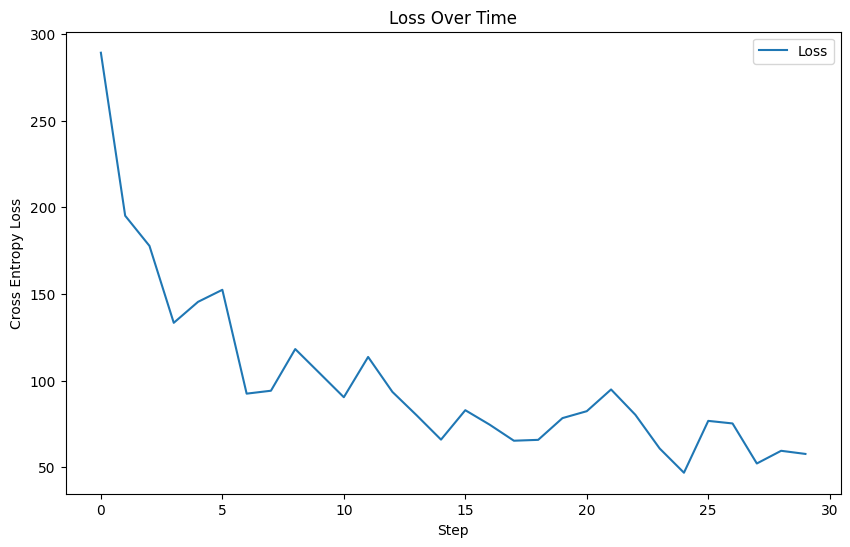

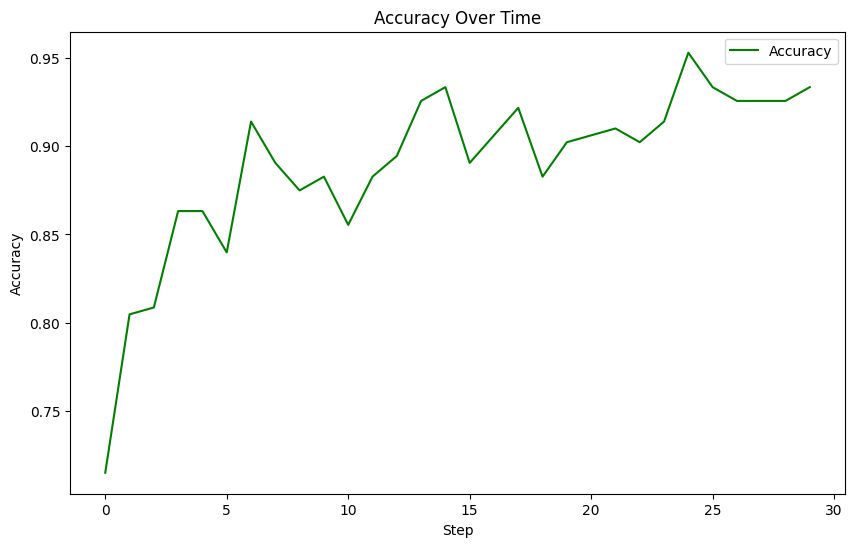

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
# Місце для вашого коду
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Loss')
plt.title('Loss Over Time')
plt.xlabel('Step')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


# Виведіть графік точності
# Місце для вашого коду
plt.figure(figsize=(10, 6))
plt.plot(accuracy_history, label='Accuracy', color='green')
plt.title('Accuracy Over Time')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Обчисліть точність навченої нейромережі
# Місце для вашого коду
train_pred = neural_net(x_train)
train_accuracy = accuracy(train_pred, y_train)

print(f"Training accuracy: {train_accuracy}")
# Тестування моделі на тестових даних
# Місце для вашого коду
test_pred = neural_net(x_test)
test_accuracy = accuracy(test_pred, y_test)

print(f"Test accuracy: {test_accuracy}")

Training accuracy: 0.9226833581924438
Test accuracy: 0.9006999731063843


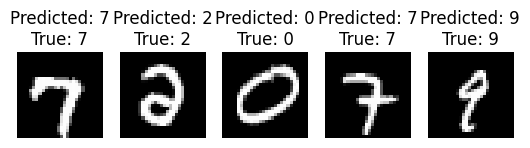

In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
# Вибір випадкових зображень
num_images = 5
random_indices = np.random.choice(x_test.shape[0], num_images)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Отримання передбачень від моделі
predictions = neural_net(sample_images)

# Візуалізація результатів
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(np.reshape(sample_images[i], [28, 28]), cmap='gray')
    plt.title(f'Predicted: {np.argmax(predictions[i])}\nTrue: {sample_labels[i]}')
    plt.axis('off')

plt.show()

# ВИСНОВКИ

Наша модель показала високу точність на тренувальному наборі (близько 92.27%) та на тестовому наборі (близько 90.07%), що свідчить про її ефективність та здатність узагальнювати на нових даних.

При тестуванні на п'яти випадкових зразках з тестового набору, модель правильно класифікувала всі зображення.